<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Demand-Elasticity" data-toc-modified-id="Demand-Elasticity-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Demand Elasticity</a></span></li><li><span><a href="#Deterministic-Model-Formulation" data-toc-modified-id="Deterministic-Model-Formulation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Deterministic Model Formulation</a></span></li><li><span><a href="#Finding-the-Optimal-Vector:-An-Optimization-Example-in-Python" data-toc-modified-id="Finding-the-Optimal-Vector:-An-Optimization-Example-in-Python-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Finding the Optimal Vector: An Optimization Example in Python</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

Content taken from [here][1] from the author [Jean-René Gauthier][2].

Turns out, selling lemonade is a perfect scenario to introduce dynamic pricing and price optimization techniques. In this post, we'll be finding an optimal price for our glasses of lemonade using some basic methodology in Python in order to maximize our revenue.

In revenue management literature, our lemonade stand would be a case of:

Time-dated items: In a nutshell, that means that I can only sell my lemonade for a certain amount of time. In my case, I could sell lemonades between about 9 a.m. and the time I was expected to be home for dinner; let's say 7 p.m. So I can sell lemonade for only 10 hours.

Perishable capacity with no salvage value: After spending most of the day in the sun, my lemonade will go bad and turn sour by 7-8 p.m. I couldn't sell the remaining glasses (even at discount!) to my younger neighbor Cedric across the street to give to his sisters. He didn't like the taste.

Marketplace with no competing products (monopolistic situation): I didn't try to sell anything besides lemonade and I was lucky enough to be the only kid in the neighborhood selling it. The fourth graders running the lemonade mafia were living across town.

Absence of inventory replenishment: I biked to the store in the morning to buy my lemons and sugar, but didn't have time to go back to the store during lunch. I was stuck with whatever inventory I bought in the morning with no prospect of adding to it during the day.

In addition to these characteristics, we will add a few limiting features to simplify our approach to price optimization. We will make the assumptions that there is:

An infinite number of customers: The customer population size does not enter in the model

Customers are myopic: In other words, customers buy as soon as the price is less than the one they are prepared to pay. Some customers are savvier than others and can modify their behaviors according to your pricing strategy. However, we will ignore them for now.

These assumptions are somewhat simplistic, but they will allow us to cover the basic concepts behind price optimization without going over complicated edge cases and mathematical formulation. Those will be the subject of future posts!

First, let's go over the mathematical formulation of the problem.

[1]:https://www.datascience.com/resources/notebooks/python-dynamic-pricing
[2]:https://www.datascience.com/blog/author/jean-rene-gauthier

# Setup

To solve the constrained problem below, we use [scipy optimize][1].

[1]:https://docs.scipy.org/doc/scipy/reference/optimize.html

In [12]:
from __future__ import division, print_function

import os
import sys
import numpy as np
import scipy
import pandas as pd
import itertools
from seaborn import heatmap
import scipy.optimize as optimize

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 6)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demand Elasticity

Demand for our lemonade will occur during times $t \in (1, 2,..,10)$ hours after breakfast. The price of a lemonade at time $t$ is denoted by $p_t$. The demand for glass of price p and time t is represented by $x(p, t)$. One can also express the price as a function of demand and time, $p(x, t)$. We will make the assumption that $x$ is continuously differentiable wrt $p$.

Our task is to find the optimal price for each hour of the day in order to maximize our revenue. The task of finding the optimal price during the day $p_t$ can be expressed as follows:

Maximize revenue objective function: $\sum_{t=1}^{10} p_t x_t$ (1)

Subject to the following constraints:

Inventory limitation: $\sum_{t=1}^{10} x_t \leq s_0$  (2)

Positive demand:  $x_t \geq 0 \forall t$     (3)

Equation 2 essentially means that we can't sell more glasses than our inventory allows, and equation 3 limits our demand to the domain of positive values.

In [18]:
def price(x, a=200, b=10, d=10, t=np.linspace(1, 10, 10)):
    """ Returns the price given a demand x and time t
    See equation 4 above"""

    return (a - b * x) * d / (d + t)


def demand(p, a=200, b=10, d=10, t=np.linspace(1, 10, 10)):
    """ Return demand given an array of prices p for times t
    (see equation 5 above)"""

    return 1.0 / b * (a - p * (d + t) / d)

# Deterministic Model Formulation

Let's consider the first case where the demand function $x(p_t, t)$ is known ahead of time and can be expressed by a deterministic function. In practice, one can rarely express the demand function with some simple deterministic model. Constraining the demand function is where a lot of the work behind price optimization comes in and will be the subject of future posts.

For simplicity, let's assume we already know the lemonade pricing curve and that this pricing curve can be expressed as a function of demand xt and time t:

$$ p(x_t,t) = (A-Bx_t) \frac{D}{D+t}$$   (4)

A, B, and D are constants that can be changed to reproduce a variety of scenarios (price is expressed in pennies). There is no strong rationale behind this function, except that it mimics the behaviors you expect to observe in reality. It may be more intuitive to look at the problem from a demand perspective by expressing $x$ as a function of $p$ and $t$ as such:

$$ x(p_t, t) = \frac{1}{B}\Big(A-p_t \frac{D+t}{D} \Big)$$   (5)

You can think of the demand $x(p_t, t)$ as expressed in units of "glasses of lemonade." (Note that I took this example from the [Supply Chain Engineering][1] textbook.)

In principle, one can solve this problem by optimizing over the demand x or price p. If you use demand, then you have to express the price as a function of x in equation 1 and vice versa for p. These two approaches, optimizing over demand or price, are equivalent. In this example, we will optimize over x.

As mentioned above, equation 4 mimics a reasonable behavior we intuitively expect:

p goes down when xt goes up. However, we see that when xt > A/B, the price becomes negative. This is obviously a problem. In order to avoid such scenario, we will add one constraint: Demand limit xt < A/B.

Another desired feature is the fact that, for a fixed demand xt, price goes down with time t.
Let's plot a few demand curves (equation 5) for a few different values of the price p and time t to get an intuitive sense for what this deterministic model looks like in practice. In the example below, we use the values of A = 200, B = 10, D = 10.

In the figure below, we see that demand goes down with price (which is reasonable!). We also see that for a fixed price, demand goes down with time, which is also an expected behavior. Note that for price > 100, we start seeing some negative values. This implies that price has to be ≤ 100 in this model.

[1]:https://link.springer.com/book/10.1007/978-1-84996-017-5

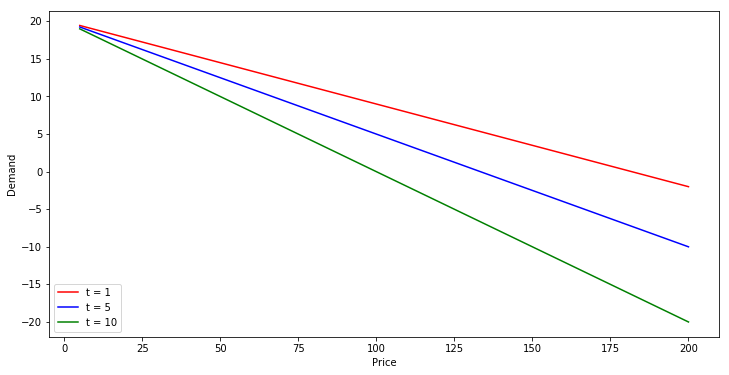

In [7]:
# Let's explore the different demand curves:

price_vals = np.array([5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 100.0, 200.0])
t_vals = np.array([1, 5, 10])
colors = ['red', 'blue', 'green']

for time, color in zip(t_vals, colors):
    plt.plot(
        price_vals,
        demand(price_vals, t=time),
        color=color,
        label='t = {}'.format(time))
plt.legend(loc=3)
plt.xlabel("Price")
plt.ylabel('Demand')
plt.grid(False)
plt.show()

You can also look at a heatmap showing demand (unconstrained by inventory limits) for different values of p and t 

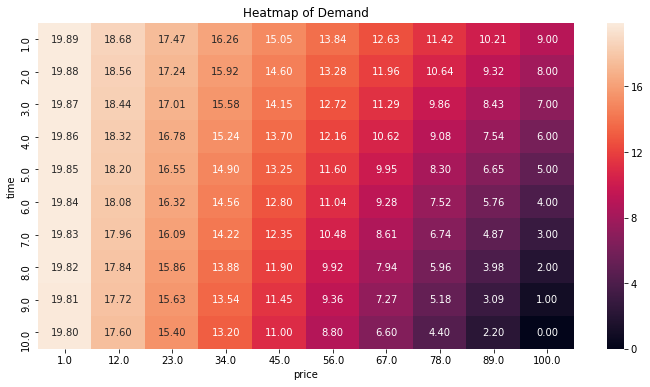

In [8]:
# Let's look at a 2D revenue map:

t_vals = np.linspace(1, 10, 10)
p_vals = np.linspace(1, 100, 10)
tmp = list(itertools.product(t_vals, p_vals))
rev_df = pd.DataFrame(tmp, columns=['time', 'price'])
rev_df['demand'] = rev_df.apply(
    lambda row: demand(row['price'], t=row['time']), axis=1)
rev_df['revenue'] = rev_df.apply(
    lambda row: row['price'] * row['demand'], axis=1)
rev_df_demand = rev_df.pivot('time', 'price', values='demand')
heatmap(rev_df_demand, annot=True, fmt=".2f")
plt.title('Heatmap of Demand')

Finally, an identical heatmap can be generated for revenue (x x p) for different values of p and t, unconstrained by inventory limits:

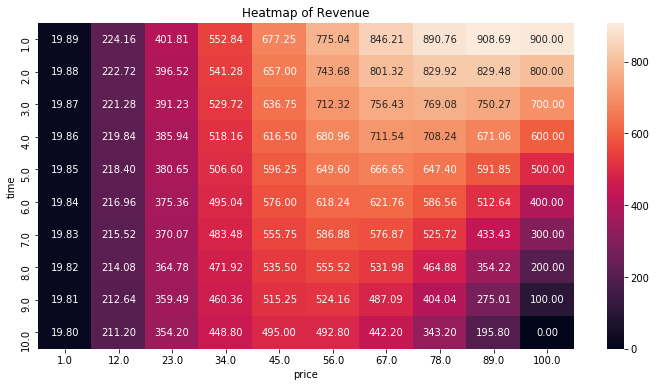

In [9]:
rev_df_revenue = rev_df.pivot('time', 'price', values='revenue')
heatmap(rev_df_revenue, annot=True, fmt=".2f")
plt.title('Heatmap of Revenue')

We see in the heatmap above that a good strategy to optimize revenue would be to start by having high prices at the beginning of the sale (top right corner) and slowly decreasing the price as time elapses (bottom middle).

# Finding the Optimal Vector: An Optimization Example in Python

We will use the example above and adopt an initial inventory s0 = 150 with model parameters A = 200, B = 10, and D = 10. Let's start by writing the objective function (equation 1):

In [10]:
def objective(x_t, a=200, b=10, d=10, t=np.linspace(1, 10, 10)):
    """ Objective function takes a vector of demand x_t and
    returns the sum of demand x price for the time period
    of interest.

    We multiply by -1.0 as the optimization routine we will
    use *minimizes* the objective function.
    """
    return -1.0 * np.sum(x_t * price(x_t, a=a, b=b, d=d, t=t))

This objective function is subject to the following constraints: 

In [11]:
def constraint_1(x_t, s_0=150):
    """ Inventory constraint. s_0 - np.sum(x_t) >= 0.
    This is an inequality constraint. See more below.
    """
    return s_0 - np.sum(x_t)


def constraint_2(x_t):
    """ Positive demand. Another inequality constraint x_t >= 0 """
    return x_t


def constraint_3(x_t, a=200, b=10):
    """ Maximum demand. Another inequality constraint """
    return (a / b) - x_t

In the cell below, we provide initial starting values, bound on the values of xt and re-write the constraints we defined as a dictionary. The minimization routine we are using takes these bounds and constraints as arguments.

The constraints could be of type "eq" or "ineq". In the case of "eq", the outcome of the constraint has to be equal to zero. In the "ineq" case, that outcome can be ≥ 0. That's the reason why we formulated the constraint {1,2,3}() functions the way we did.

In [13]:
# Model parameters :
s_0 = 150.0
a = 200.0
b = 10.0
d = 10.0
t = np.linspace(1, 10, 10)

# Starting values :
x_start = 3.0 * np.ones(len(t))

# bounds on the values :
bounds = tuple((0, 20.0) for x in x_start)

# Constraints :
constraints = ({
    'type': 'ineq',
    'fun': lambda x, s_0=s_0: constraint_1(x, s_0=s_0)
}, {
    'type': 'ineq',
    'fun': lambda x: constraint_2(x)
}, {
    'type': 'ineq',
    'fun': lambda x, a=a, b=b: constraint_3(x, a=a, b=b)
})

In the cell below, we'll call the optimization routine using the SLSQP method. That stands for Sequential Least SQuares Programming. An intro to SLSQP is outside the scope of this post, but a good intro can be [found here][1].

[1]:https://www.math.uh.edu/~rohop/fall_06/Chapter4.pdf

In [14]:
opt_results = optimize.minimize(
    objective,
    x_start,
    args=(a, b, d, t),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints)

In [15]:
print(opt_results)

     fun: -6687.714030531401
     jac: array([-0.00073242, -0.00195312,  0.00280762, -0.00494385,  0.00384521,
       -0.00036621,  0.00115967, -0.00213623, -0.00024414,  0.00097656])
 message: 'Optimization terminated successfully.'
    nfev: 157
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([ 9.99996057,  9.99989841, 10.00011689,  9.99989972, 10.0000114 ,
       10.00007382, 10.00013996,  9.99964962, 10.00000733, 10.00015055])


We have a successful optimization run! As one can see, the values of x (demand) are very much constant with time. (The values of x are listed in increasing order of time from t = 1 to t = 10). We expect a total (and maximal) revenue of fun = 6687.71 cents (66.87 dollars). We also see that the total demand is:

In [16]:
np.sum(opt_results['x'])

99.99990828084269

which is less than the available inventory (s0). That's also a good sign. (Note that we already know the answer to this problem. The published solution matches ours and was derived using a different technique. See References below for more information.) Let's take a look at the associated prices (in cents) of each value of xt 

In [17]:
print(price(opt_results['x'], a=a, b=b, d=d, t=t))

[90.90944936 83.33417991 76.92217774 71.42928768 66.66659067 62.49953862
 58.82270611 55.55750212 52.63154039 49.99924723]


As one can see, prices are decreasing over time, which is a sensible behavior. It's very similar to what we expected based on the revenue heatmap above. So the strategy here is to start the day by charging about \$0.90 per glass of lemonade and slowly decreasing the price by a few cents every hour. By the end of the day, my profit should be \$66.87 - C0 = \$16.87, which is enough for me to get my beloved hockey cards. As an exercise, I recommend you generate a large number of random demand scenarios (all constrained by inventory limits) and compare the revenues generated by these scenarios with the optimal value above. Just to convince yourself that you've indeed found the optimal solution!

# Summary

This post was meant to be an introduction to dynamic pricing and how to obtain the optimal pricing strategy to maximize revenue. In most business settings, however, you will not know the demand curve ahead of time. This is an idealistic scenario. In future posts, we will explore more realistic scenarios. Stay tuned! 